In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
chars = sorted(list(set(''.join(words))))
str_to_inx = {str:inx for inx, str in enumerate(chars, start=1)}
str_to_inx['.'] = 0
inx_to_str = {str:inx for inx, str in str_to_inx.items()}
inx_to_str

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [5]:
# build the dataset
random.shuffle(words)
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for word in words:
    word = block_size * '.' + word + '.'
    # for ch1, ch2, ch3, ch4 in zip(word, word[1:], word[2:], word[3:]):
    #     # print(''.join([ch1, ch2, ch3]), '=>', ch4)
    #     X.append([str_to_inx[ch] for ch in [ch1, ch2, ch3]])
    #     Y.append(str_to_inx[ch4])
    end_inx = block_size
    for start_inx, char in enumerate(word[block_size:]):
        X.append([str_to_inx[ch] for ch in word[start_inx:end_inx]])
        Y.append(str_to_inx[char])
        end_inx += 1


X, Y = torch.tensor(X), torch.tensor(Y)
X

tensor([[ 0,  0,  0],
        [ 0,  0,  2],
        [ 0,  2, 18],
        ...,
        [25,  1, 14],
        [ 1, 14, 14],
        [14, 14,  1]])

In [6]:
# data set splits
train_range = math.ceil(len(X) * 0.8)
dev_range = (len(X) - train_range) // 2

training_set = X[:train_range]
dev_set = X[train_range:train_range+dev_range]
test_set = X[train_range+dev_range:]

y_training_set = Y[:train_range]
y_dev_set = Y[train_range:train_range+dev_range]
y_test_set = Y[train_range+dev_range:]

assert training_set.nelement() + dev_set.nelement() + test_set.nelement() == X.nelement(), "Bad split"

In [88]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 30), generator=g, requires_grad=True)
W1 = torch.randn((90, 300), generator=g, requires_grad=True)
b1 = torch.randn(300, generator=g, requires_grad=True)
W2 = torch.randn((300, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [8]:
sum(p.nelement() for p in parameters) # number of parameters in total

36237

In [9]:
# find the best learning rate in [0.001, 1] interval
learning_rates_exponent = torch.linspace(start=-3, end=0, steps=10000) # 10**(-3) = 0.001, 10**0 = 1
learning_rates = 10**learning_rates_exponent # exponential step
learning_rates

tensor([0.0010, 0.0010, 0.0010,  ..., 0.9986, 0.9993, 1.0000])

The distributed representation is learned based on the usage of words (C's weights - flattened vector of 3 letters). This allows words(or letters) that are used in similar ways to result in having similar representations, naturally capturing their meaning. This can be contrasted with the crisp but fragile representation in a bag of words model where, unless explicitly managed, different words have different representations, regardless of how they are used.

Why use batches? Training time. A lot of semi-accurate steps beats a small # of accurate steps(the whole training set)

In [158]:
# train
inxs = []
losses = []
for i in range(300000):
    # minibatch construct
    inx = torch.randint(0, training_set.shape[0], (64,))

    # forward pass
    emb = C[training_set[inx]] # grab only those rows from the minibatch 
    h = torch.tanh(emb.view(-1, 90) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_training_set[inx]) + 0.01*(W2**2).mean()
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    # l_r = learning_rates[i]
    # l_r = 0.01 if i < 50000 else 0.001
    l_r = 0.001
    for p in parameters:
        p.data += -l_r * p.grad

    #stats
    inxs.append(i)
    losses.append(loss.item())
loss.item() # best loss 2.14

2.159741163253784

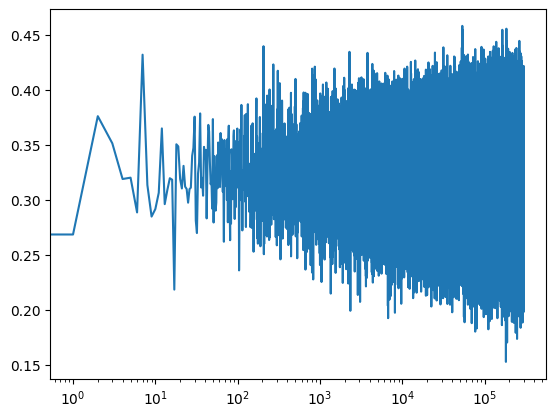

In [161]:
plt.plot(inxs, np.log10(losses))
plt.xscale("log")
# l[np.argmin(losses)]

In [159]:
# dev set valuation
emb = C[dev_set] # grab only those rows from the minibatch 
h = torch.tanh(emb.view(-1, 90) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_dev_set) 
loss.item()

2.164926528930664

In [160]:
# test set valuation
emb = C[test_set] # grab only those rows from the minibatch 
h = torch.tanh(emb.view(-1, 90) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_test_set) 
loss.item()

2.163883686065674

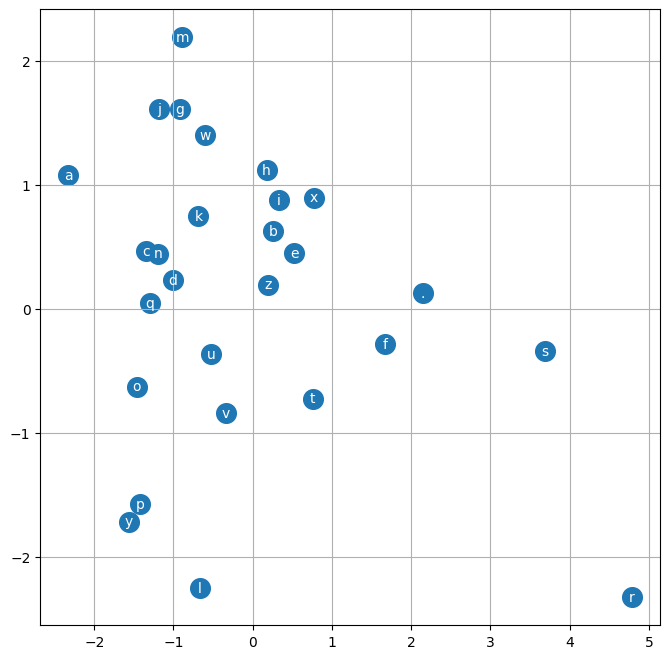

In [83]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
# makes sense only if C.shape = -1x3x2
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), inx_to_str[i], ha="center", va="center", color='white')
plt.grid('minor')

In [162]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
	out = '.' * block_size
	while True:
		emb = C[torch.tensor([str_to_inx[x] for x in out[-block_size:]])] # (1,block_size,d)
		h = torch.tanh(emb.view(1, -1) @ W1 + b1)
		logits = h @ W2 + b2
		probs = F.softmax(logits, dim=1)
		inx = torch.multinomial(probs, num_samples=1, generator=g).item()
		out = out + inx_to_str[inx]
		if inx == 0:
			break
    
	print(out.replace('.', ''))

carman
amille
khi
mri
reety
skaasha
jazonel
delynn
jareei
nellaiah
maihvik
leigh
ham
join
quinn
suli
walianni
wanelo
dearyxi
jaxen
